In [1]:
import os
import re
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as pyo
import plotly.graph_objs as go

pyo.init_notebook_mode(connected=True)

DATA_PATH = './data'
plt.rcParams['figure.figsize'] = (14, 8)
%matplotlib inline

In [2]:
with open(os.path.join(DATA_PATH, 'mapbox_public_key')) as f:
    mapbox_access_token = f.readline().strip()

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, 'Chicago_crimes.csv'))
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Updated On'] = pd.to_datetime(df['Updated On'], format='%m/%d/%Y %I:%M:%S %p')
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,11688584,JC264879,2019-05-15 23:59:00,014XX N SEDGWICK ST,1310,CRIMINAL DAMAGE,TO PROPERTY,CHA APARTMENT,False,True,...,-87.638510,"(41.908430535, -87.638509526)",41.0,14926.0,37.0,309.0,46.0,54.0,14.0,198.0
1,11688595,JC264934,2019-05-15 23:50:00,002XX W 37TH ST,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,CHA PARKING LOT/GROUNDS,False,False,...,-87.633128,"(41.827275105, -87.633128349)",26.0,14924.0,35.0,296.0,48.0,37.0,23.0,170.0
2,11688599,JC264875,2019-05-15 23:48:00,029XX N ASHLAND AVE,0860,THEFT,RETAIL THEFT,GROCERY FOOD STORE,True,False,...,-87.668504,"(41.935432921, -87.668504341)",16.0,4449.0,57.0,712.0,40.0,22.0,5.0,173.0
3,11688953,JC265362,2019-05-15 23:45:00,101XX S VAN VLISSINGEN RD,0820,THEFT,$500 AND UNDER,STREET,False,False,...,-87.570203,"(41.711059693, -87.570202971)",43.0,21202.0,48.0,252.0,37.0,25.0,19.0,249.0
4,11688579,JC264864,2019-05-15 23:32:00,016XX S WESTERN AVE,0454,BATTERY,AGG PO HANDS NO/MIN INJURY,SIDEWALK,False,False,...,-87.685826,"(41.859049992, -87.68582611)",8.0,14920.0,33.0,4.0,23.0,43.0,21.0,151.0


In [4]:
# amount of NaN in each column
temp = df.isna().sum()
temp[temp > 0].sort_values(ascending=False)

Ward                          614822
Community Area                613496
Historical Wards 2003-2015     84256
Community Areas                81540
Boundaries - ZIP Codes         81493
Wards                          81429
Police Districts               80465
Police Beats                   80442
Census Tracts                  79386
Y Coordinate                   64473
X Coordinate                   64473
Longitude                      64473
Latitude                       64473
Location                       64473
Zip Codes                      64473
Location Description            4998
District                          47
Case Number                        4
dtype: int64

### There is a two main situation when we have missing values. In one situation we don't have exact location of crime (coordinates, zip codes, etc). It's about 1 % of all records. In another one we don't know even approximate location of incidents (ward or community area). It's about 10% of all records.

In [5]:
temp_nona = df.loc[df['Ward'].notna(), ['Primary Type', 'Year', 'ID']]
temp_na = df.loc[df['Ward'].isna(), ['Primary Type', 'Year', 'ID']]

In [6]:
temp = temp_nona.groupby(['Primary Type'])[['ID']].count().rename(columns={'ID': 'without_NaN'})
temp = 100 * temp / temp.sum()

temp2 = temp_na.groupby(['Primary Type'])[['ID']].count().rename(columns={'ID': 'with_NaN'})
temp2 = 100 * temp2 / temp2.sum()

temp_df = pd.concat([temp, temp2], axis=1, sort=False)
temp_df['diff'] = temp_df['without_NaN'] - temp_df['with_NaN']

temp_df.sort_values(by='without_NaN', ascending=False).head(10)

,without_NaN,with_NaN,diff
THEFT,21.167800,19.972285,1.195515
BATTERY,18.168520,19.251426,-1.082906
CRIMINAL DAMAGE,11.382490,11.640117,-0.257627
NARCOTICS,10.399747,10.949836,-0.550088
ASSAULT,6.206504,6.474069,-0.267564
OTHER OFFENSE,6.194409,6.437961,-0.243552
BURGLARY,5.756645,5.282667,0.473978
MOTOR VEHICLE THEFT,4.568930,5.345450,-0.776520
DECEPTIVE PRACTICE,4.070192,2.904255,1.165937
ROBBERY,3.774654,3.781908,-0.007254


### There isn't much difference between distribution of crimes with known and unknown location of crime.

In [7]:
temp = temp_nona.groupby(['Year'])[['ID']].count().rename(columns={'ID': 'without_NaN'})

temp2 = temp_na.groupby(['Year'])[['ID']].count().rename(columns={'ID': 'with_NaN'})

temp_df = pd.concat([temp, temp2], axis=1, sort=False)
temp_df

,without_NaN,with_NaN
Year,,
2001,4157,481597.0
2002,353641,133115.0
2003,475927,19.0
2004,469362,22.0
2005,453716,1.0
2006,448110,3.0
2007,437010,5.0
2008,427060,4.0
2009,392692,3.0


### It seems that most NaN values refer to the years 2001 and 2002. I’ll just look at crimes since 2003.

In [8]:
del temp, temp2, temp_nona, temp_na
gc.collect()

95

In [9]:
# remove unuseful columns and drop NaN it's about 10% of dataset
df.drop(['Case Number', 'IUCR', 'Location', 'X Coordinate', 'Y Coordinate', 
         'Wards', 'Police Beats', 'Police Districts', 'Boundaries - ZIP Codes',
         'Historical Wards 2003-2015', 'Zip Codes', 'Community Area', 'Census Tracts'], axis=1, inplace=True)
df.dropna(how='any', inplace=True)

In [10]:
df['Month'] = df['Date'].dt.month.astype('uint8')
df['Weekday'] = df['Date'].dt.weekday.astype('uint8')
df['Day'] = df['Date'].dt.day.astype('uint8')
# Block without house number
df['Street'] = df['Block'].str.extract('[0-9|X] [N|E|S|W] (.*)', expand=False)
# df.drop(['Block'], axis=1, inplace=True)

df['Day_diff'] = df['Updated On'] - df['Date']
df['Day_diff'] = df['Day_diff'].dt.days
df['Day_diff'] = df['Day_diff'].astype('uint16')

In [11]:
# Fill unknown values and convert to less consumin datatype
dtypes = {'ID': 'uint32', 'Beat': 'uint16', 'Year': 'uint16', 'District': 'uint8', 'Ward': 'uint8', 
          'Community Areas': 'uint8'}
for key, value in dtypes.items():
    df[key] = df[key].astype(value)

In [12]:
# Dataframe to map column 'FBI Code' and human readable description
if 'fbi_codes.csv' not in os.listdir('./data'):
    fbi_df = pd.DataFrame({'Code': [], 'Description': [], 'Serious offense': []})
    temp = pd.read_html('http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html')
    # pattern that retrive desription and code
    pattern = re.compile(r' ([\w& -]*) (\(\d{2}[A-Z]?\))')
    # Retrive information about National Incident-Based Reporting System (NIBRS) codes
    # Crimes classified to less or more serious
    for i, serious_offense in enumerate([True, False]): 
        fbi_str = temp[0].iloc[3+i][1].replace('\xa0', ' ').replace('  ', ' ')
        fbi_list = pattern.findall(fbi_str)
        for desc, code in fbi_list:
            fbi_df = fbi_df.append(pd.DataFrame({'Code': [code[1:-1]], 'Description': [desc], 
                                                 'Serious offense': [serious_offense]}), ignore_index=True)
    fbi_df['Serious offense'] = fbi_df['Serious offense'].astype('bool')
    fbi_df.to_csv('./data/fbi_codes.csv', index=False)
else:
    fbi_df = pd.read_csv(os.path.join(DATA_PATH, 'fbi_codes.csv'), dtype={'Serious offense': 'bool'})

# Map of Chicago

In [13]:
# use for ignoring errors in coordinates
df['Longitude'].mean(), df['Longitude'].std(), df['Latitude'].mean(), df['Latitude'].std()

(-87.67148914346922,
 0.05885440027036391,
 41.84165736530477,
 0.08622710957441593)

In [14]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

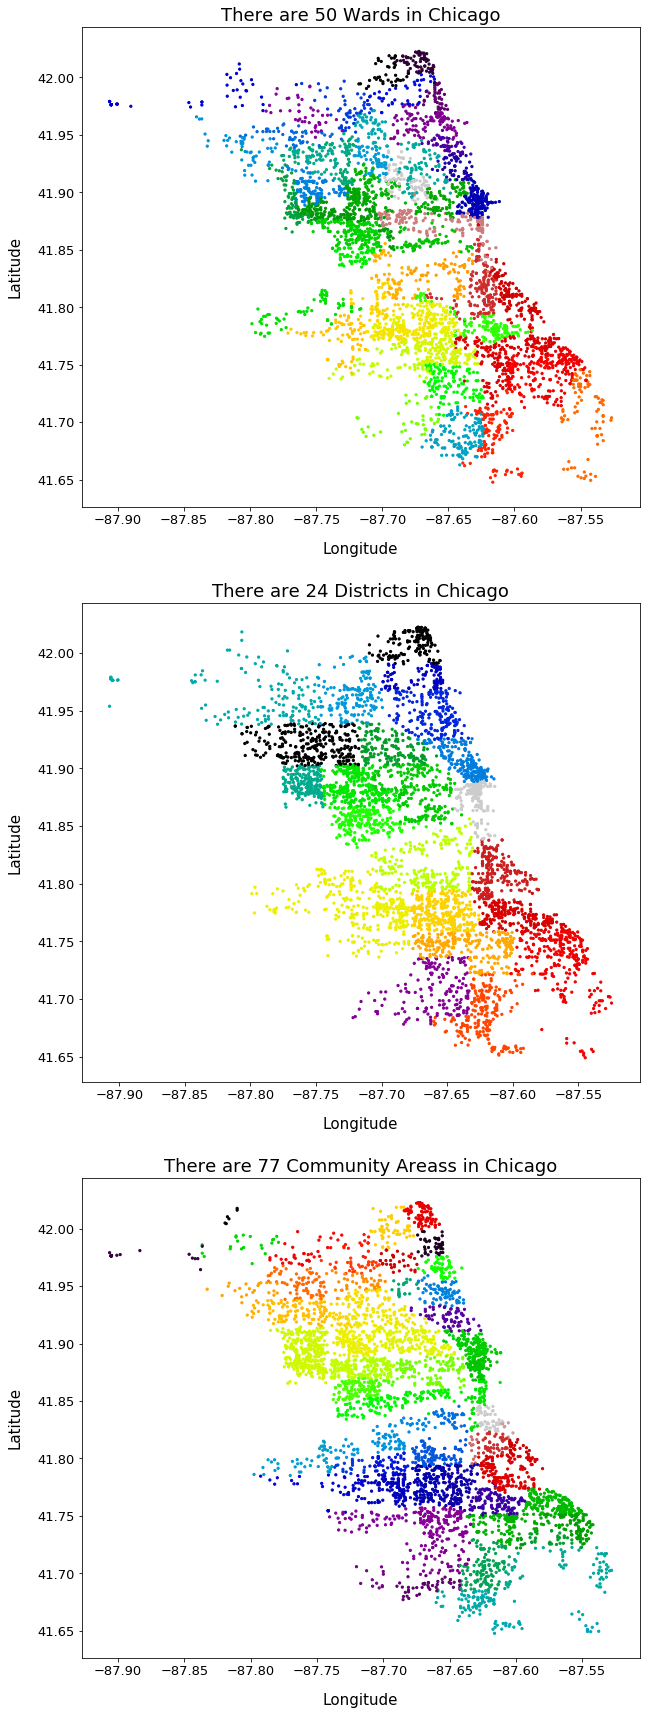

In [15]:
temp_list = ['Ward', 'District', 'Community Areas']
fig, ax = plt.subplots(len(temp_list), 1)
n = 10
fig.set_figheight(n * len(temp_list))
fig.set_figwidth(n)

for i, column in enumerate(temp_list):
    temp = df[['Latitude', 'Longitude', column]].copy()

    # removing some anomalies
    temp = temp.loc[temp['Longitude'].between(-90, -85) & temp['Latitude'].between(39, 43), :]
    temp = temp.sample(5000)
    
    ax[i].scatter(temp['Longitude'], temp['Latitude'], c=temp[column], s=5, 
                cmap=discrete_cmap(df[column].nunique(), 'nipy_spectral_r'))
    ax[i].set_title('There are {} {}s in Chicago'.format(df[column].nunique(), temp_list[i]), 
                    fontdict={'fontsize': 18})
    ax[i].set_xlabel('Longitude', size=15, labelpad=15)
    ax[i].set_ylabel('Latitude', size=15, labelpad=15)
    ax[i].tick_params(labelsize=13)

In [16]:
temp = df['FBI Code'].value_counts().reset_index().merge(fbi_df, left_on='index', right_on='Code')\
.rename(columns={'FBI Code': 'counts'}).drop(['Code', 'index'], axis=1)
temp['pct'] = temp['counts'] / temp['counts'].sum()

# create color dict
colrs = (plt.cm.tab20.colors + plt.cm.tab20c.colors)[:temp['Description'].shape[0]]
colrs = dict(zip(temp['Description'], colrs))

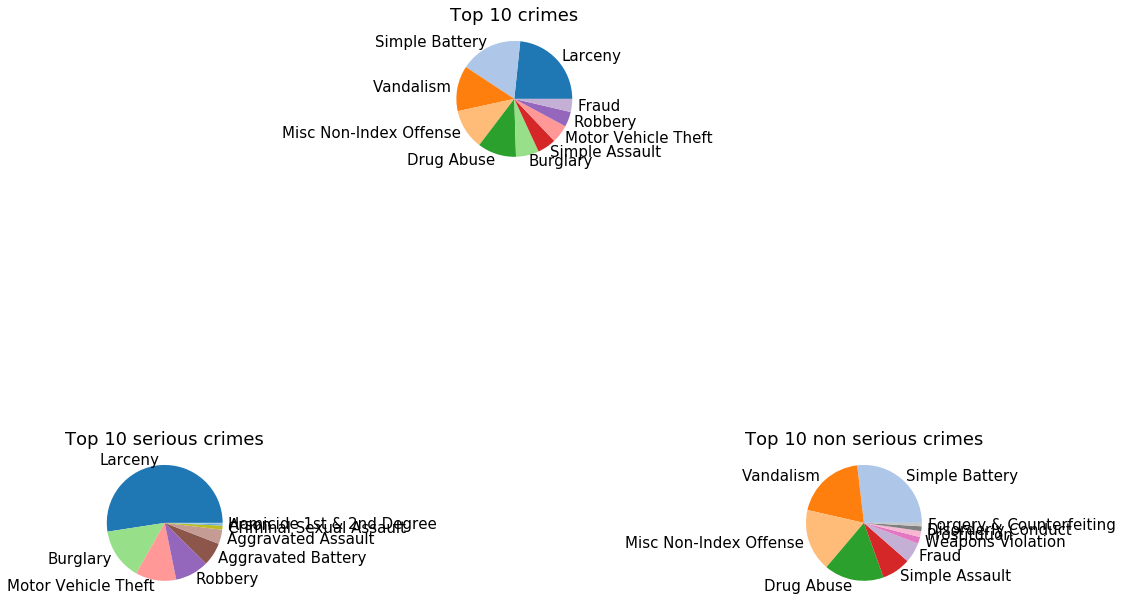

In [17]:
fig = plt.figure(figsize=(15, 12))

ax1 = plt.subplot2grid((2, 3), (0, 1))
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (1, 2))

titles = ['Top 10 crimes', 'Top 10 serious crimes', 'Top 10 non serious crimes']


for i, ax in enumerate([ax1, ax2, ax3]):
    if i == 0:
        _temp = temp.sort_values('counts', ascending=False).head(10)
    if i == 1:    
        _temp = temp.loc[temp['Serious offense'] == True].sort_values('counts', ascending=False).head(10)
    if i == 2:
        _temp = temp.loc[temp['Serious offense'] == False].sort_values('counts', ascending=False).head(10)
    
    
    wedges, texts = ax.pie(x=_temp['counts'], labels=_temp['Description'],
                            colors=[colrs[label] for label in _temp['Description']])
    
    [text.set_size(15) for text in texts]
    ax.set_title(titles[i], fontdict={'fontsize': 18})

plt.tight_layout()
del _temp

In [18]:
# Location Description for whole years, 2003 and 2017
temp = df.loc[df['Year'] == 2003, 'Location Description'].value_counts()
temp = temp * 100 / temp.sum()
in_2003 = temp.reset_index().rename(columns={'index': 'Location', 'Location Description': 'pct_2003'})
in_2003['pct_2003'] = in_2003['pct_2003'].apply(round, args=(1,))

temp = df.loc[df['Year'] == 2017, 'Location Description'].value_counts()
temp = temp * 100 / temp.sum()
in_2017 = temp.reset_index().rename(columns={'index': 'Location', 'Location Description': 'pct_2017'})
in_2017['pct_2017'] = in_2017['pct_2017'].apply(round, args=(1,))

temp = df['Location Description'].value_counts()
temp = temp * 100 / temp.sum()
temp = temp.reset_index().rename(columns={'index': 'Location', 'Location Description': 'pct_total'})
temp['pct_total'] = temp['pct_total'].apply(round, args=(1,))
temp.merge(in_2003, how='left', left_on='Location', right_on='Location')\
.merge(in_2017, how='left', left_on='Location', right_on='Location').head(10)

,Location,pct_total,pct_2003,pct_2017
0,STREET,25.8,30.7,22.7
1,RESIDENCE,16.6,17.1,17.0
2,APARTMENT,10.9,8.3,12.5
3,SIDEWALK,10.2,7.9,7.9
4,OTHER,3.7,3.8,4.2
5,PARKING LOT/GARAGE(NON.RESID.),2.8,3.0,3.1
6,ALLEY,2.2,2.3,2.0
7,"SCHOOL, PUBLIC, BUILDING",2.1,2.5,1.3
8,RESIDENCE-GARAGE,1.9,2.1,1.7
9,SMALL RETAIL STORE,1.8,1.6,2.5


### During years location of incident changed. Amount of incidents on streets decreased, but increased in apartments. In other location amount of incident is pretty constant.

In [19]:
temp = df.groupby(by=['FBI Code'])['Arrest'].mean().reset_index()\
.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Description', 'Arrest']]
temp = temp.sort_values(by='Arrest')
temp = temp.append({'Description': 'Overall', 'Arrest': df['Arrest'].mean()}, ignore_index=True)

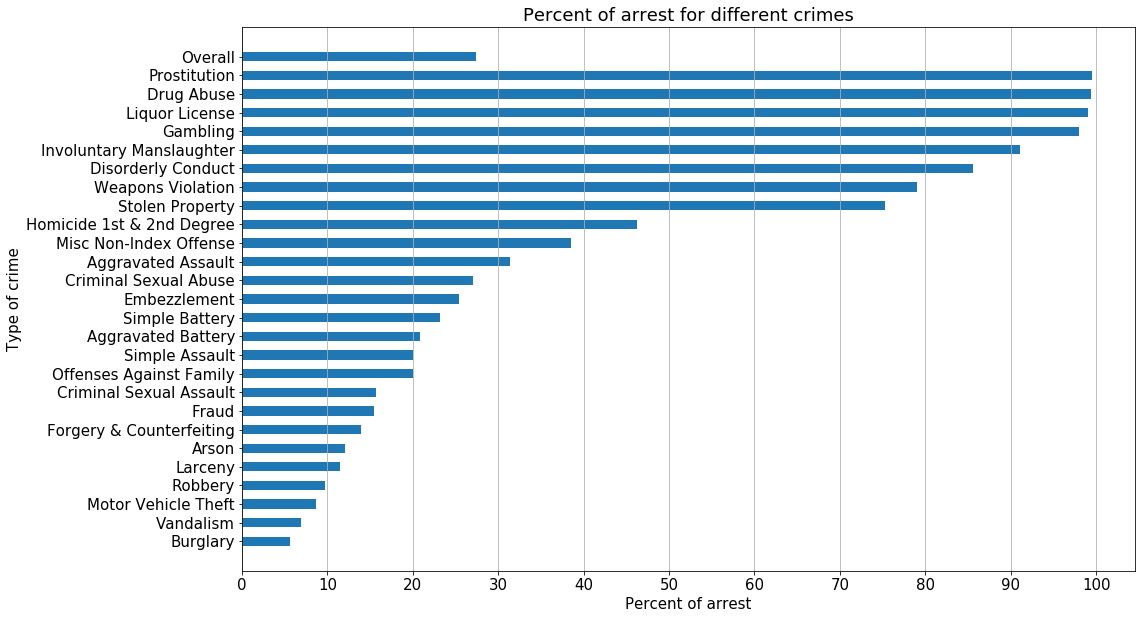

In [20]:
fig = plt.figure(figsize=(16, 10))

plt.barh(y=range(temp.shape[0]), width=temp['Arrest'] * 100, height=0.5, tick_label=temp['Description'])

ax = fig.get_axes()[0]
ax.set_title('Percent of arrest for different crimes', size=18)
ax.xaxis.grid(True)
ax.set_xlabel('Percent of arrest', size=15)
ax.set_ylabel('Type of crime', size=15)
ax.set_xticks([i for i in range(0, 110, 10)])
plt.setp(ax.get_xticklabels(), size=15)
plt.setp(ax.get_yticklabels(), size=15);

In [21]:
temp = df.groupby(by=['FBI Code'])['Domestic'].mean().reset_index()\
.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Description', 'Domestic']]
temp = temp.sort_values(by='Domestic')
temp = temp.append({'Description': 'Overall', 'Domestic': df['Domestic'].mean()}, ignore_index=True)

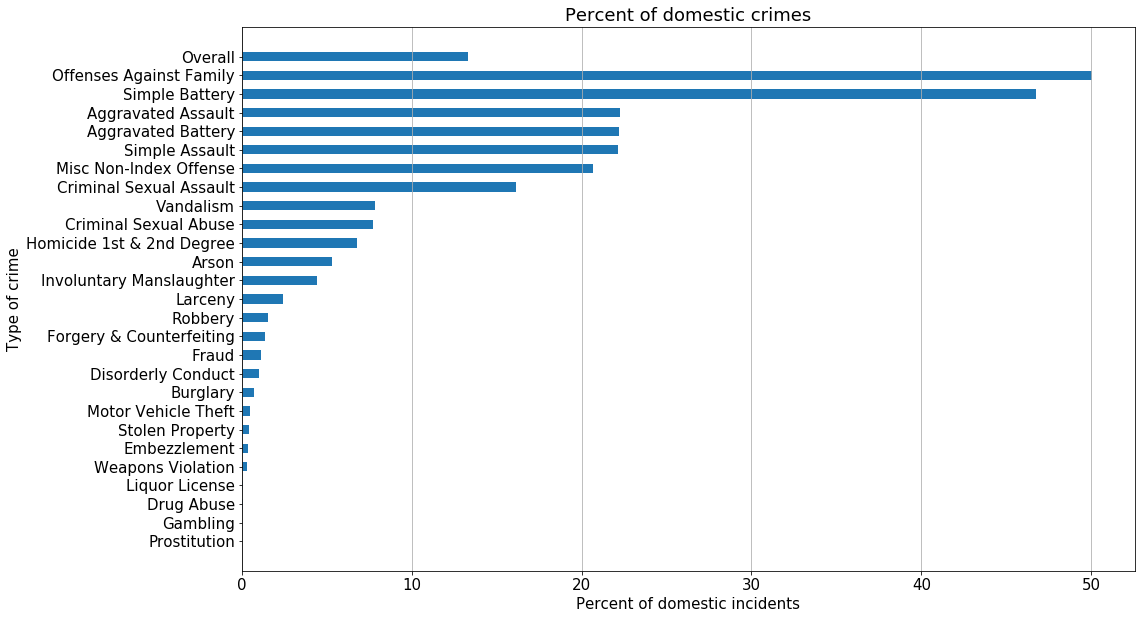

In [22]:
fig = plt.figure(figsize=(16, 10))

plt.barh(y=range(temp.shape[0]), width=temp['Domestic'] * 100, height=0.5, tick_label=temp['Description'])

ax = fig.get_axes()[0]
ax.set_title('Percent of domestic crimes', size=18)
ax.xaxis.grid(True)
ax.set_xlabel('Percent of domestic incidents', size=15)
ax.set_ylabel('Type of crime', size=15)
ax.set_xticks([i for i in range(0, 60, 10)])
plt.setp(ax.get_xticklabels(), size=15)
plt.setp(ax.get_yticklabels(), size=15);

### Most of incident isn't a domestic ones. Only 'Offenses Against Family' and 'Simple Battery' frequntly happen at home. Overall domestic incidents is only 13%.

In [23]:
# Count for Community Area
temp = df.groupby(by=['Community Areas'])['ID'].count().reset_index()
temp['pct'] = temp['ID'] * 100 / temp['ID'].sum()

# Find mean longitude and latitude for every area
com_cor = df.groupby(by=['Community Areas'])[['Longitude', 'Latitude']].mean().reset_index()
com_cor = temp.merge(com_cor).sort_values(by='ID', ascending=False).reset_index()

temp = df.merge(fbi_df, left_on='FBI Code', right_on='Code') [['Community Areas', 'Serious offense', 'ID']]
temp = temp.groupby(by=['Community Areas']).agg({'Serious offense': 'mean', 'ID': 'count'}).reset_index()
temp['Ser_pct'] = temp['Serious offense'] * 100

com_cor = com_cor.merge(temp)

In [24]:
# Count for street
temp = df.groupby(by=['Street'])['ID'].count().reset_index().sort_values(by='ID', ascending=False)
arr_most_crime = temp['Street'].head(50).values
temp['pct'] = temp['ID'] * 100 / temp['ID'].sum()
temp.head(5)

,Street,ID,pct
2265,STATE ST,104339,1.687455
1780,MICHIGAN AVE,93074,1.505268
376,ASHLAND AVE,75684,1.224023
1205,HALSTED ST,75415,1.219673
2444,WESTERN AVE,64731,1.046882


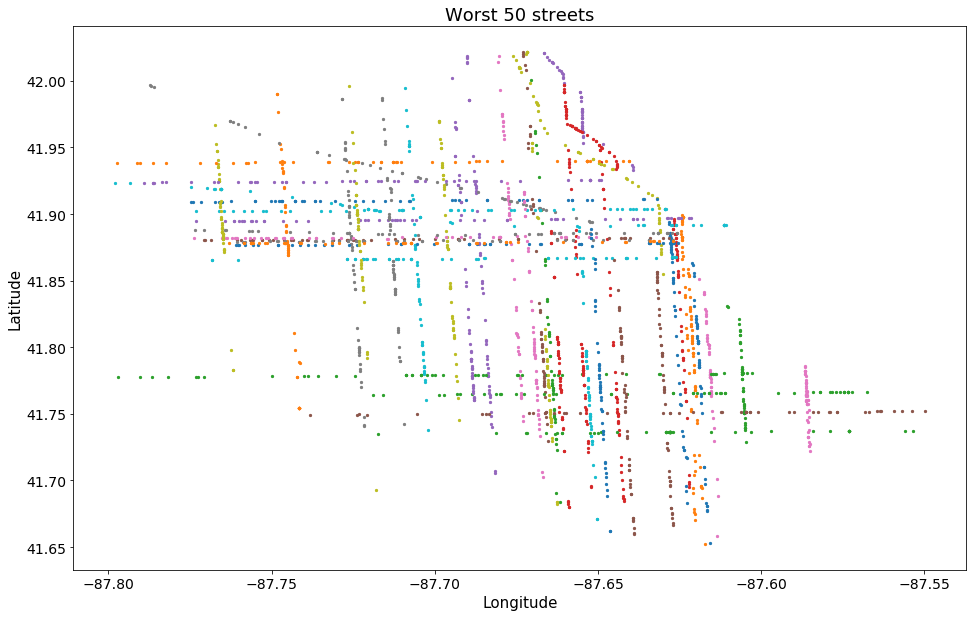

In [25]:
fig = plt.figure(figsize=(16, 10))

_temp = df.loc[(df['Longitude'].between(-90, -85) & df['Latitude'].between(39, 43)), 
               ['Longitude', 'Latitude', 'Street']].copy()
               
for street in arr_most_crime:
    sam = _temp.loc[_temp['Street'] == street, ['Longitude', 'Latitude']].sample(50)
    plt.scatter(sam['Longitude'], sam['Latitude'], s=5)
    
plt.title('Worst 50 streets', size=18)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
del _temp

### Almost all of them are long streets

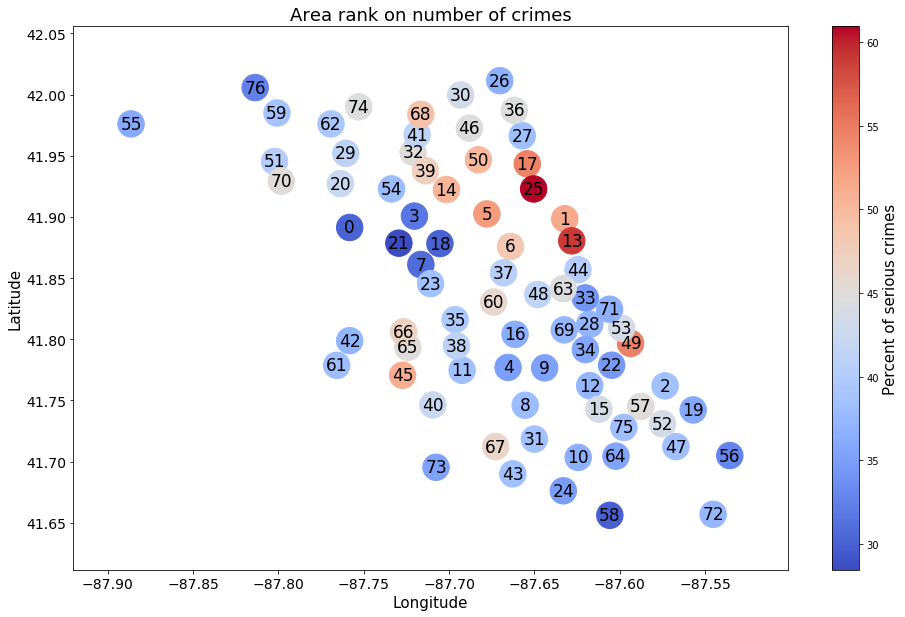

In [26]:
fig = plt.figure(figsize=(16, 10))

plt.scatter(com_cor['Longitude'], com_cor['Latitude'], s=700, 
            c=com_cor['Ser_pct'], cmap='coolwarm')
cbar = plt.colorbar()
cbar.ax.set_ylabel(ylabel='Percent of serious crimes', size=15)

for row_number, row in com_cor.iterrows():
    plt.text(row['Longitude'], row['Latitude'], s=row_number, ha='center', va='center', color='k', size=17)

plt.title('Area rank on number of crimes', size=18)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14);

### Area rank isn't strongly correlated with percent of serious crimes

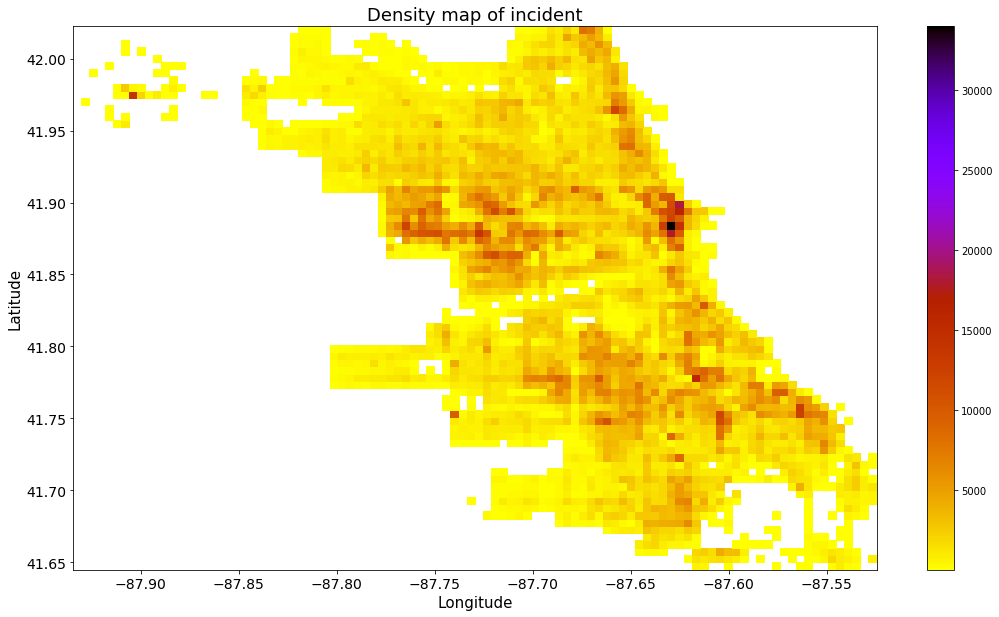

In [27]:
fig = plt.figure(figsize=(18, 10))

temp = df.loc[(df['Longitude'].between(-90, -85) & df['Latitude'].between(39, 43)), 
               ['Longitude', 'Latitude']].copy()

h, x, y, a = plt.hist2d(temp['Longitude'].dropna(), temp['Latitude'].dropna(), cmin=10, 
                        bins=(100, 75), cmap='gnuplot_r')
plt.colorbar()
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Density map of incident', fontsize=18);

### There is some especially bad place 

In [28]:
# fill nan
h = np.nan_to_num(h)
# find max value
first_max = np.unravel_index(h.argmax(), h.shape)
h[first_max]

33963.0

In [29]:
# incident around worst point on map
temp = df.loc[(df['Longitude'].between(x[first_max[0]-1], x[first_max[0]+1]) \
               & df['Latitude'].between(y[first_max[1]-1], y[first_max[1]+1]))].copy()
temp = temp.merge(fbi_df, left_on='FBI Code', right_on='Code')
temp.shape

(72290, 25)

In [30]:
# Much bigger than averege in the city
temp['Serious offense'].mean()

0.6091437266565224

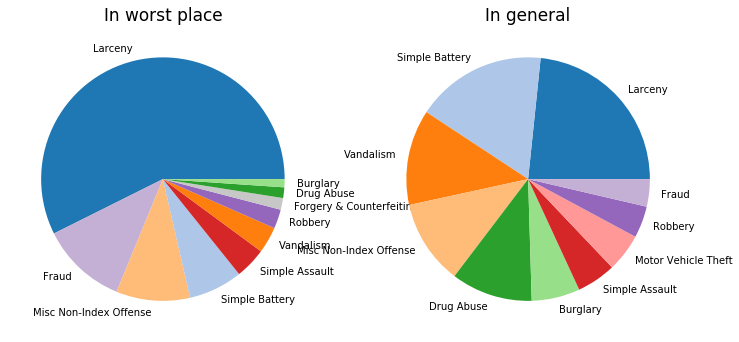

In [31]:
general = df.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Year', 'Description_y', 'ID']]
general = general.groupby('Description_y')['ID'].count().reset_index().sort_values('ID', ascending=False)
worst_palce = temp.groupby('Description_y')['ID'].count().reset_index().sort_values('ID', ascending=False)

# lot top 10
general = general.head(10)
worst_palce = worst_palce.head(10)
plt.pie
fig, ax = plt.subplots(1, 2, figsize=(2*6, 6))
ax[0].pie(x=worst_palce['ID'], labels=worst_palce['Description_y'], 
          colors=[colrs[label] for label in worst_palce['Description_y']])
ax[0].set_title('In worst place', size=17)

ax[1].pie(x=general['ID'], labels=general['Description_y'], 
          colors=[colrs[label] for label in general['Description_y']])
ax[1].set_title('In general', size=17);

### There are much more larceny incidents in worst place in Chicago.

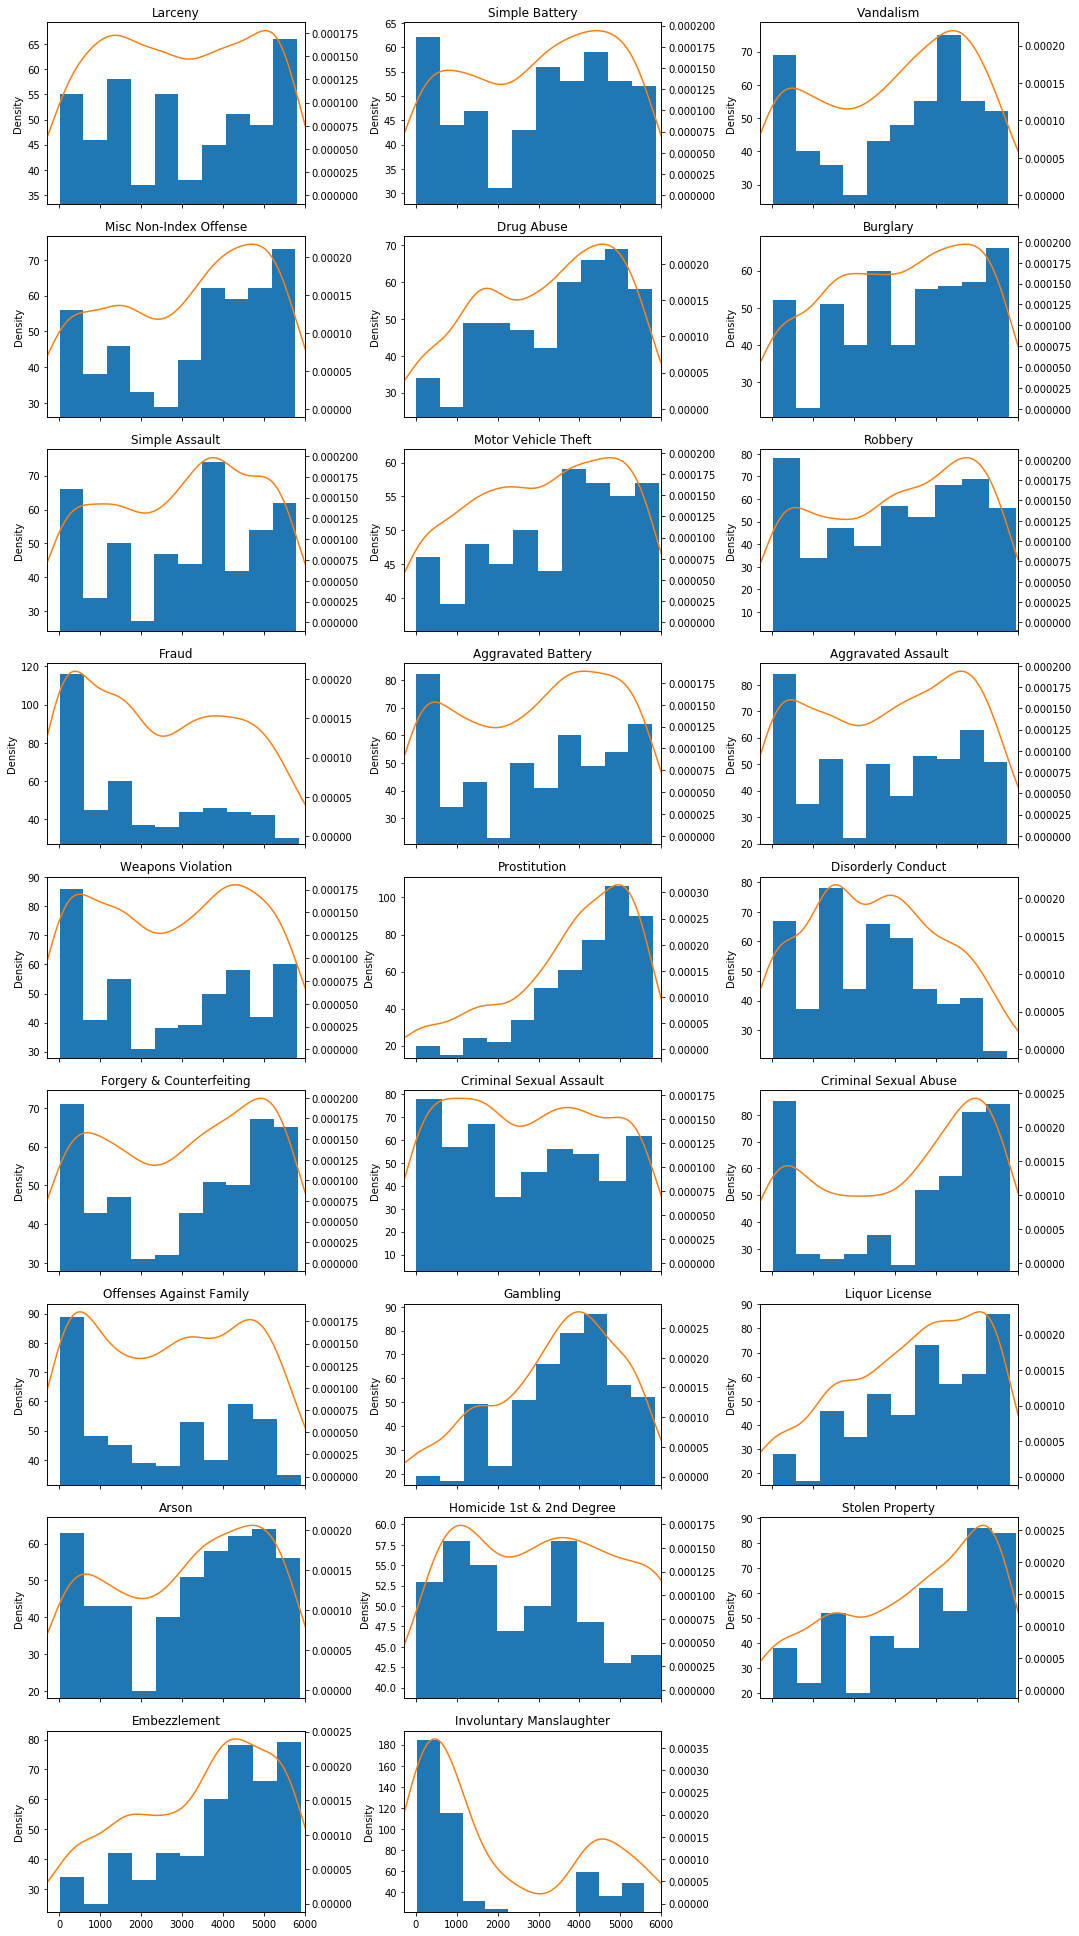

In [32]:
# list of incidents, sorted by their frequentist
l = df['FBI Code'].value_counts().reset_index()['index']

n = 3 # col
m = (len(l) - 1) // n + 1 # rows
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3), sharex=False)

for i, code in enumerate(l):
    r, c = i // n, i % n
    ax = axes[r, c]
    
    temp = df.loc[df['FBI Code'] == code, 'Day_diff'].sample(500, replace=True)
    arr, bins, pathes = ax.hist(x=temp, bins=10)
    ax.set_xlim(-300, 6000)
    ax.set_ylim(arr[arr != 0].min() * 0.9)
    ax2 = temp.plot.kde(ax=ax, secondary_y=True, title=fbi_df.loc[fbi_df['Code'] == code, 'Description'].values[0])

# hide last box
axes[-1, -1].axis('off')

fig.tight_layout()

### The distributions of days from incident till last update are different, but mostly are left skewed. It means that information about lots of incident was updated after long period of time. Perhaps it's done to follow some standard. A lot of crimes have a peak in the beginning. It can be assumed that such crimes was solved fast.

In [33]:
df['Updated On'].dt.dayofyear.value_counts().reset_index()\
.rename(columns={'index': 'Day of year', 'Updated On': 'counts'}).head()

,Day of year,counts
0,41,2754612
1,59,2661698
2,35,344654
3,124,85581
4,45,19338


In [34]:
df['Updated On'].dt.day.value_counts().reset_index()\
.rename(columns={'index': 'Day of month', 'Updated On': 'counts'}).head()

,Day of month,counts
0,10,2768173
1,28,2669612
2,4,436733
3,14,27614
4,17,20842


### Almost all change made on 10 or 28 of February. This is most likely end of reporting year for the police.

In [35]:
temp = df.groupby(by='Year')['ID'].count().reset_index()

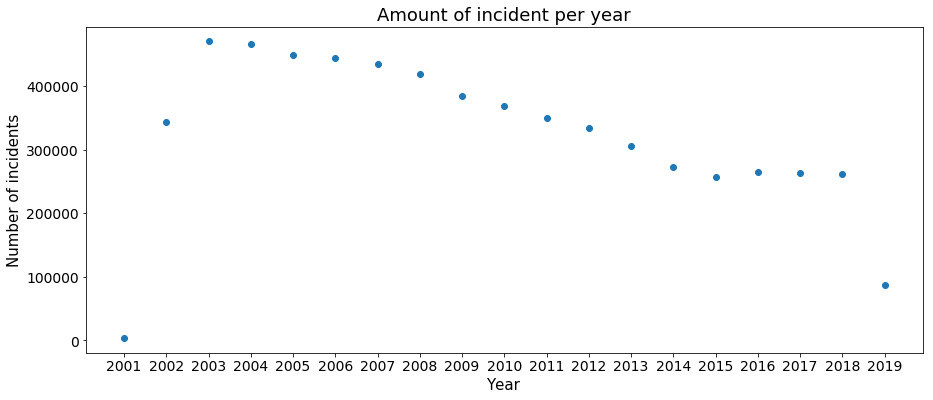

In [36]:
fig = plt.figure(figsize=(15, 6))
plt.scatter(x=temp['Year'], y=temp['ID'])

plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of incidents', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(range(2001, 2020, 1), fontsize=14)
plt.title('Amount of incident per year', fontsize=18);

### We don't have information about all incidents in 2001, 2002 and 2019. The amount of incident is going down from 2003 to 2015 and  decreased for about 55%. After 2015 number of incident is almost constant.

In [37]:
temp = df.groupby(by='Month')['ID'].count().reset_index()

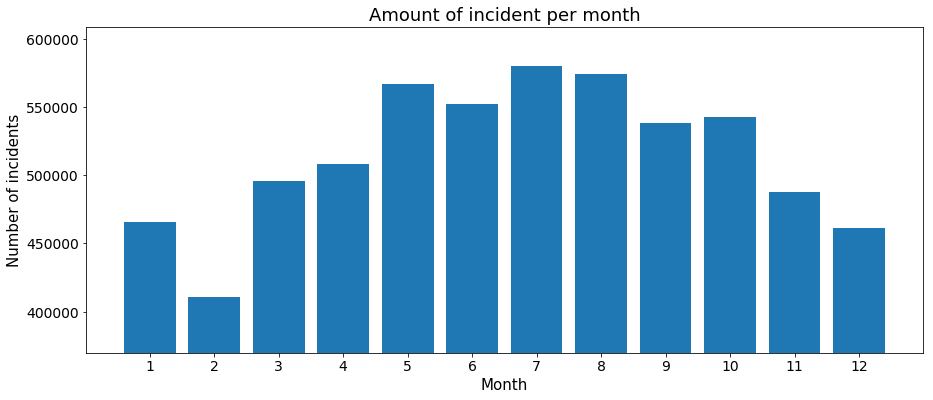

In [38]:
fig = plt.figure(figsize=(15, 6))
plt.bar(x=range(1, 13, 1), height=temp['ID'], width=0.8, align='center')
plt.ylim(temp['ID'].min() * 0.9)

plt.xlabel('Month', fontsize=15)
plt.ylabel('Number of incidents', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(range(1, 13, 1), fontsize=14)
plt.title('Amount of incident per month', fontsize=18);

### This is consistent with the statistics for the country

In [39]:
temp = df.groupby(by='Weekday')['ID'].count().reset_index()

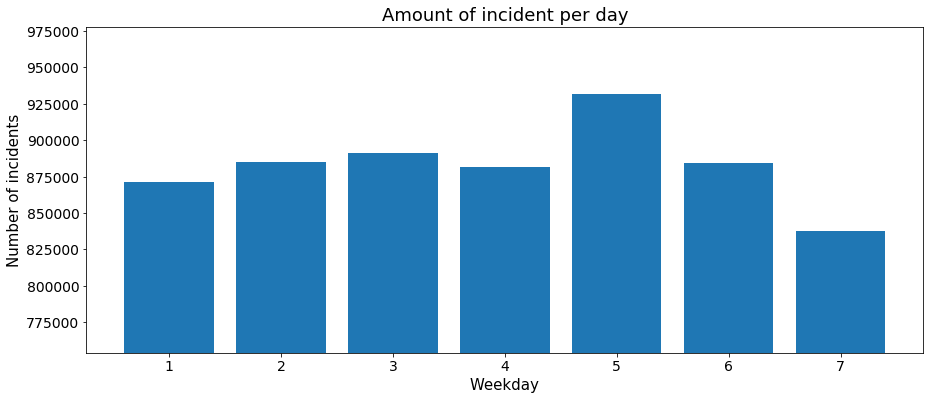

In [40]:
fig = plt.figure(figsize=(15, 6))
plt.bar(x=range(1, 8, 1), height=temp['ID'], width=0.8, align='center')
plt.ylim(temp['ID'].min() * 0.9)

plt.xlabel('Weekday', fontsize=15)
plt.ylabel('Number of incidents', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(range(1, 8, 1), fontsize=14)
plt.title('Amount of incident per day', fontsize=18);

### It's quite unusual. If we consider country level statistic it appears that weekends lead in amount of incident. In Chicago worst day is friday.

In [41]:
temp = df.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Year', 'Serious offense']]
temp = temp.groupby(by='Year')['Serious offense'].mean().reset_index()
# drop year without full information
temp = temp[2:-1]

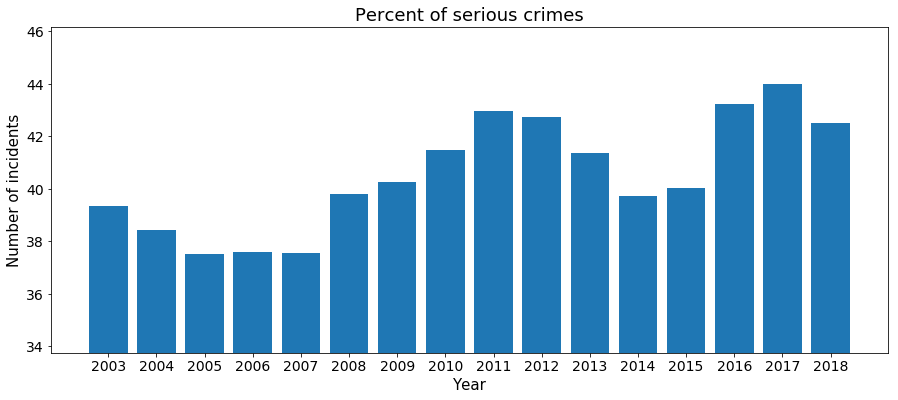

In [42]:
fig = plt.figure(figsize=(15, 6))
plt.bar(x=range(2003, 2019, 1), height=temp['Serious offense'] * 100, width=0.8, align='center')
plt.ylim(temp['Serious offense'].min() * 100 * 0.9)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of incidents', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(range(2003, 2019, 1), fontsize=14)
plt.title('Percent of serious crimes', fontsize=18);

### There is no obvious dependence. But in general proportion of serious crimes is increasing.

In [43]:
temp = df.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Year', 'Description_y', 'ID']]
temp = temp.groupby(by=['Year', 'Description_y'])['ID'].count().reset_index()

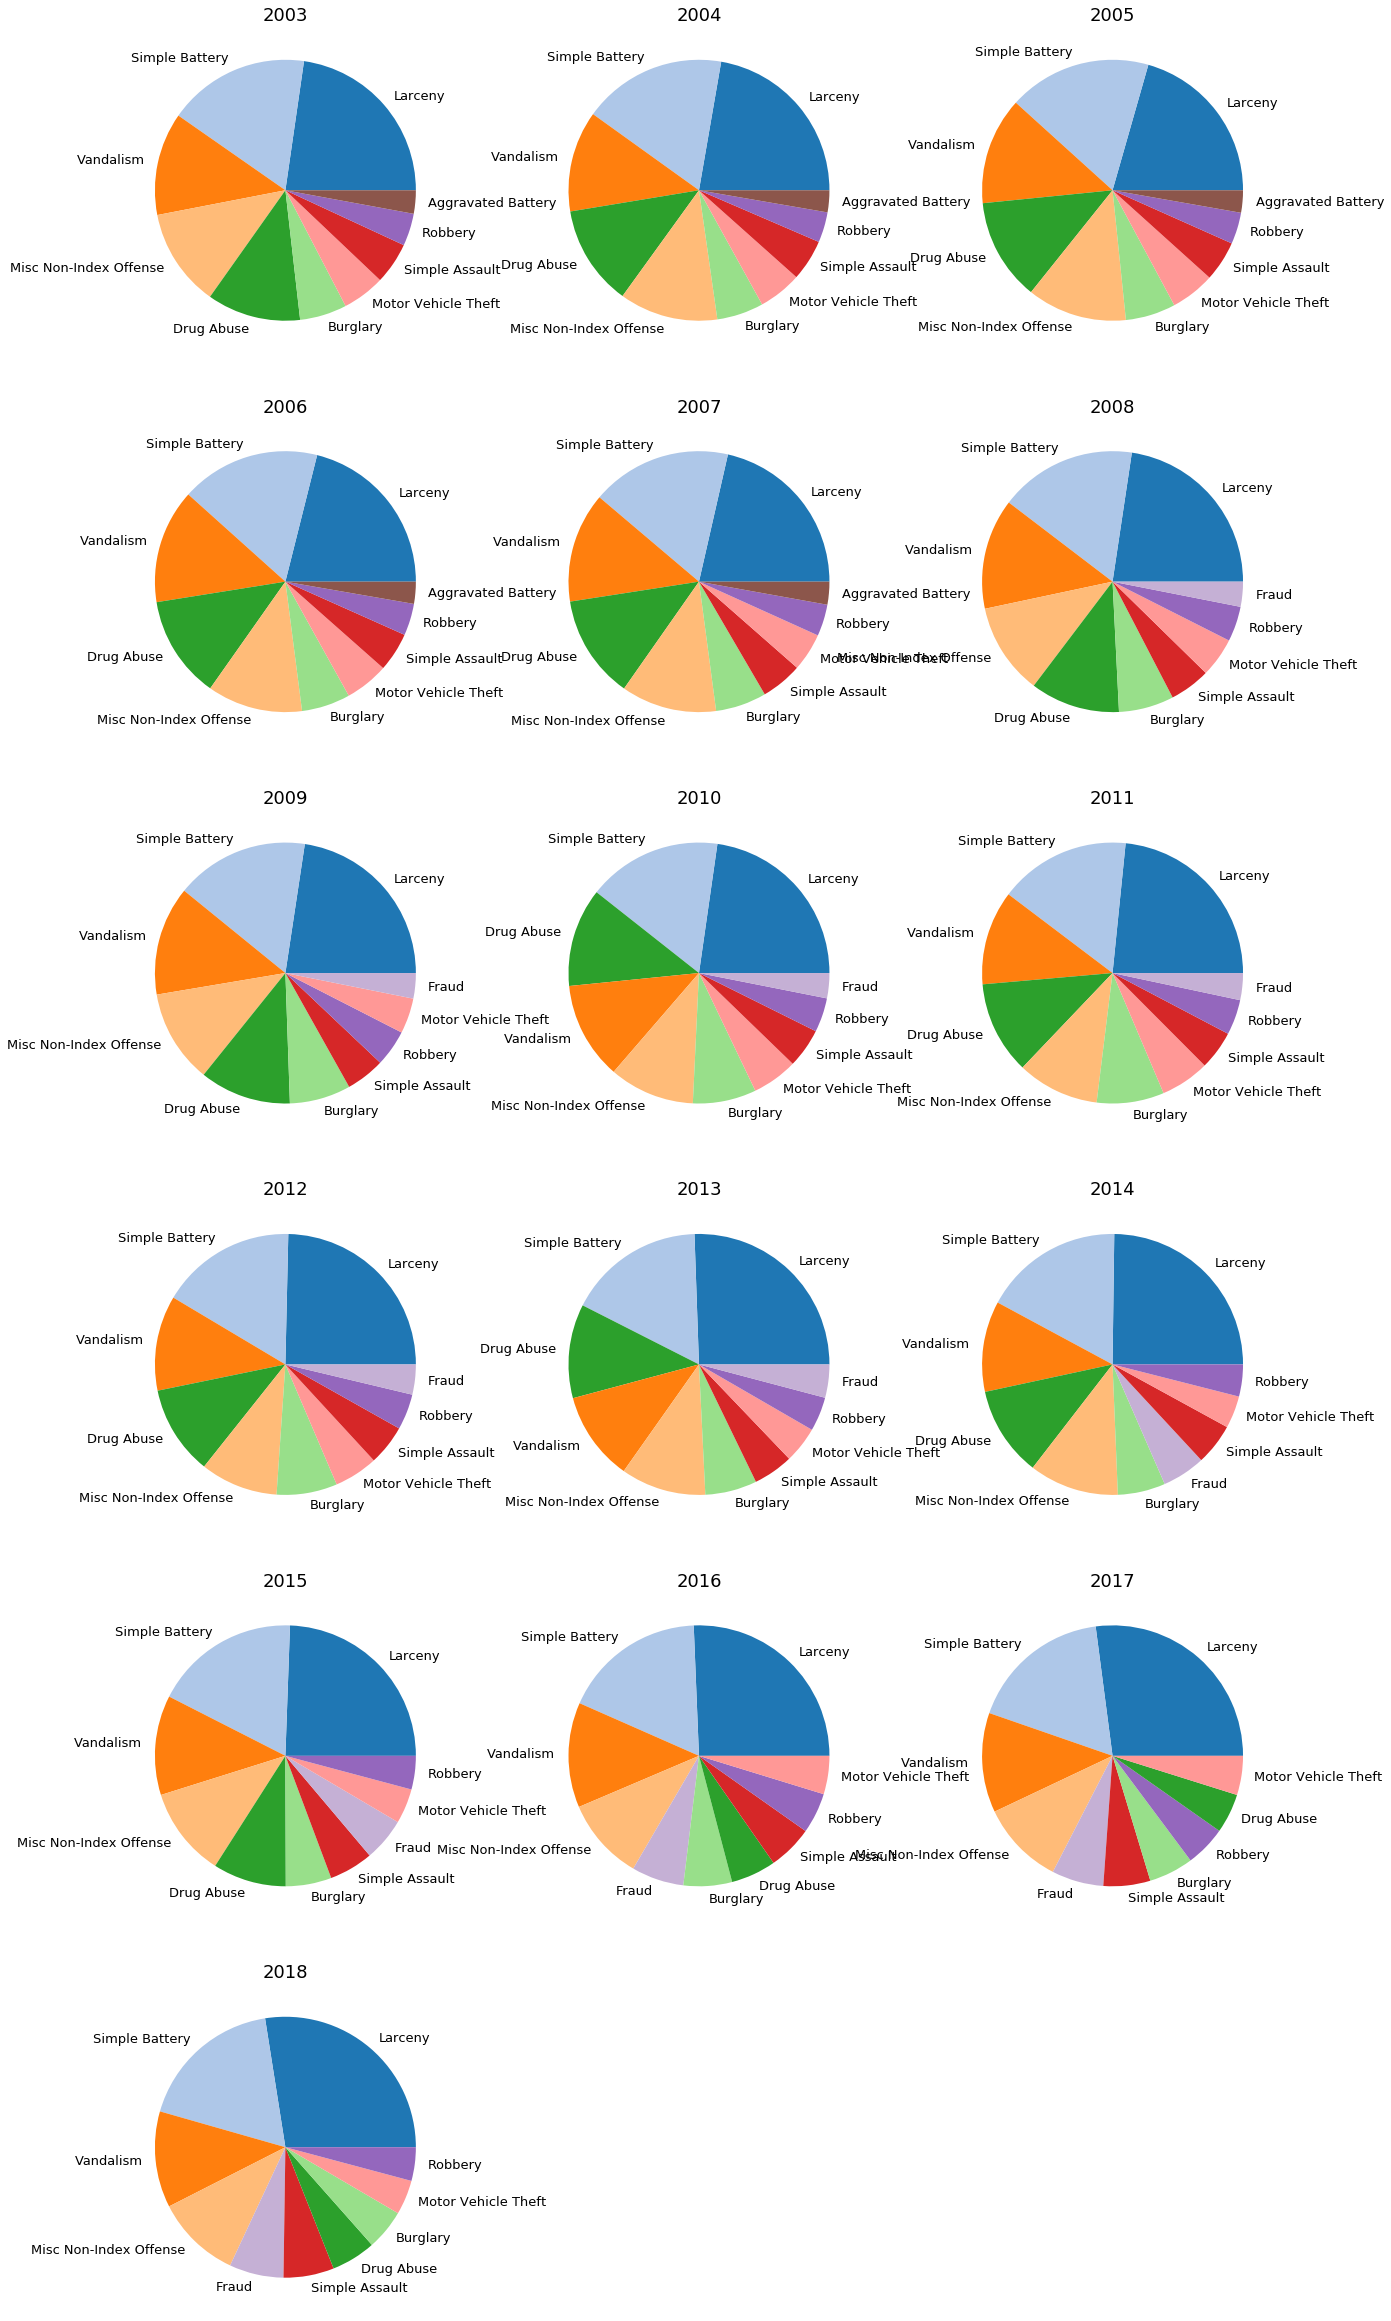

In [44]:
n = 3 # col
m = int(np.floor((16) / n + 1)) #  number of rows for 16 years
fig, axes = plt.subplots(m, n, figsize=(n * 7, m * 7))

for i, year in enumerate(range(2003, 2019, 1)):
    _temp = temp.loc[temp['Year'] == year].sort_values('ID', ascending=False).head(10)
    r = i // n
    c = i % n
    ax = axes[r, c]
    wedges, texts = ax.pie(x=_temp['ID'], labels=_temp['Description_y'], 
           colors=[colrs[label] for label in _temp['Description_y']])
    [text.set_size(13) for text in texts]
    ax.set_title(year, size=18)

for i in range(n * m - 16):
    axes.flat[-1-i].set_visible(False)
del _temp

### There is increment in larceny and fraud and decrement in drug abuse during years.